In [2]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
import os

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)

from src.predict import ChurnPredictor
from src.simulation_utils import run_simulation, run_price_sensitivity_analysis
predictor = ChurnPredictor('../config.yaml')

# Set plot style and format floats
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
# Load main configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Instantiate the predictor
model_path = f"../models/xgboost_model.pkl"
model_loaded = predictor.load_model(model_path)

# --- Define Baseline Distributions (same as before) ---
baseline_distributions = {
    'gender': ('choice', {'options': ['Male', 'Female'], 'probabilities': [0.5, 0.5]}),
    'SeniorCitizen': ('choice', {'options': [0, 1], 'probabilities': [0.84, 0.16]}),
    'Partner': ('choice', {'options': ['Yes', 'No'], 'probabilities': [0.48, 0.52]}),
    'Dependents': ('choice', {'options': ['Yes', 'No'], 'probabilities': [0.3, 0.7]}),
    'tenure': ('uniform', [1, 72]),
    'PhoneService': ('choice', {'options': ['Yes', 'No'], 'probabilities': [0.9, 0.1]}),
    'MultipleLines': ('choice', {'options': ['Yes', 'No', 'No phone service'], 'probabilities': [0.42, 0.48, 0.1]}),
    'InternetService': ('choice', {'options': ['DSL', 'Fiber optic', 'No'], 'probabilities': [0.34, 0.44, 0.22]}),
    'OnlineSecurity': ('choice', {'options': ['Yes', 'No', 'No internet service'], 'probabilities': [0.28, 0.5, 0.22]}),
    'OnlineBackup': ('choice', {'options': ['Yes', 'No', 'No internet service'], 'probabilities': [0.34, 0.44, 0.22]}),
    'DeviceProtection': ('choice', {'options': ['Yes', 'No', 'No internet service'], 'probabilities': [0.34, 0.44, 0.22]}),
    'TechSupport': ('choice', {'options': ['Yes', 'No', 'No internet service'], 'probabilities': [0.29, 0.49, 0.22]}),
    'StreamingTV': ('choice', {'options': ['Yes', 'No', 'No internet service'], 'probabilities': [0.38, 0.4, 0.22]}),
    'StreamingMovies': ('choice', {'options': ['Yes', 'No', 'No internet service'], 'probabilities': [0.38, 0.4, 0.22]}),
    'Contract': ('choice', {'options': ['Month-to-month', 'One year', 'Two year'], 'probabilities': [0.55, 0.24, 0.21]}),
    'PaperlessBilling': ('choice', {'options': ['Yes', 'No'], 'probabilities': [0.59, 0.41]}),
    'PaymentMethod': ('choice', {'options': ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], 'probabilities': [0.34, 0.23, 0.22, 0.21]}),
    'MonthlyCharges': ('normal', [64.76, 30.09]),
    'TotalCharges': ('normal', [2283.3, 2266.8])
}

INFO:src.predict:Model loaded successfully from ../models/xgboost_model.pkl


In [4]:
NUM_SIMULATIONS = 10000
price_factors = np.linspace(0.8, 1.5, 15) # Test from -20% to +50% price change

summary_df = run_price_sensitivity_analysis(
    predictor, 
    baseline_distributions, 
    price_factors, 
    NUM_SIMULATIONS, 
    n_jobs=-1  # Use all CPU cores
)

Running price sensitivity analysis for 15 scenarios using -1 cores...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch processing...
Running simulation for 10000 customers...
Using single-threaded batch proces

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 12.5min remaining: 11.0min


Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Simulation complete.
Price sensitivity analysis complete.


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 19.8min finished


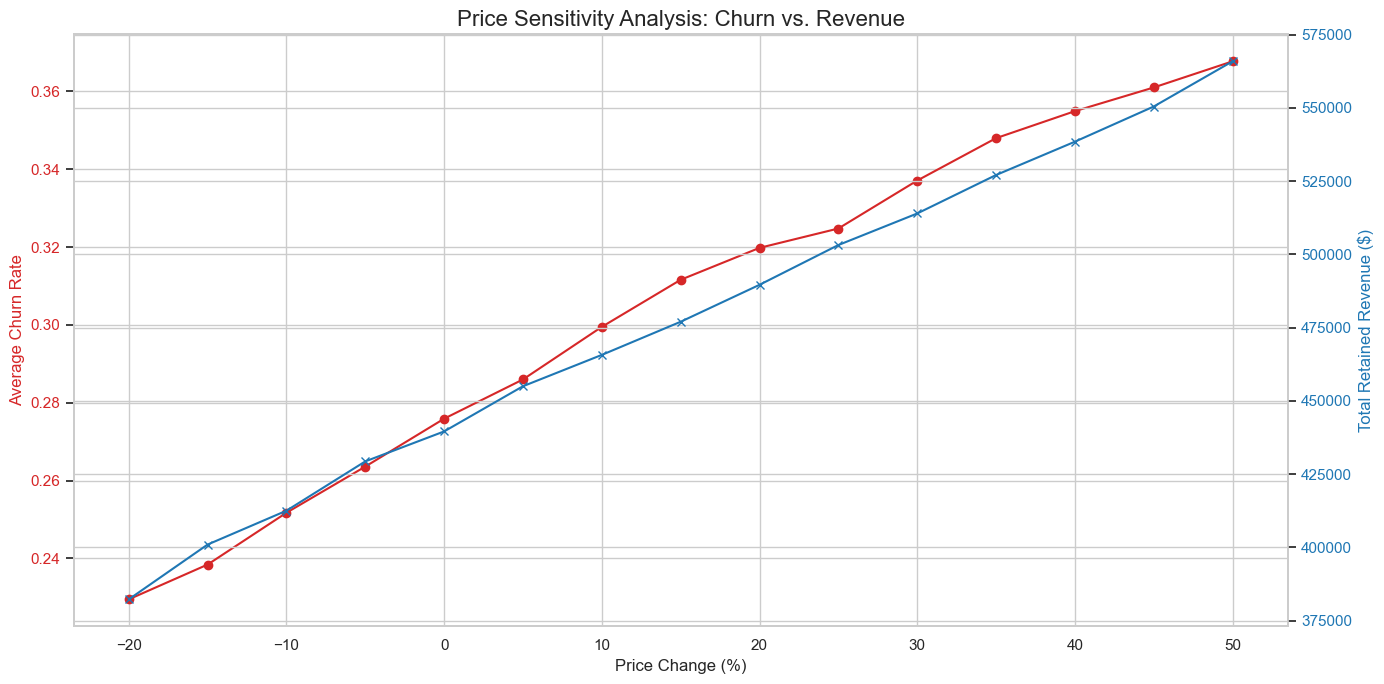

--- Optimal Scenario for Revenue ---
price_factor                   1.5000
avg_churn_rate                 0.3677
total_retained_revenue   565,922.1908
Name: 14, dtype: float64


In [7]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Average Churn Rate
color = 'tab:red'
ax1.set_xlabel('Price Change (%)')
ax1.set_ylabel('Average Churn Rate', color=color)
ax1.plot((summary_df['price_factor'] - 1) * 100, summary_df['avg_churn_rate'], color=color, marker='o', label='Avg Churn Rate')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis to plot Total Retained Revenue
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Retained Revenue ($)', color=color)
ax2.plot((summary_df['price_factor'] - 1) * 100, summary_df['total_retained_revenue'], color=color, marker='x', label='Total Retained Revenue')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Price Sensitivity Analysis: Churn vs. Revenue', fontsize=16)
fig.tight_layout()
plt.show()

# Find the optimal price point for revenue
optimal_scenario = summary_df.loc[summary_df['total_retained_revenue'].idxmax()]
print("--- Optimal Scenario for Revenue ---")
print(optimal_scenario)

In [9]:
print(f"\n--- Deep Dive into Optimal Scenario (Price Factor: {optimal_scenario['price_factor']:.2f}) ---")

# Rerun simulation for the optimal factor to get the full dataset
optimal_dist = copy.deepcopy(baseline_distributions)
mean, std = optimal_dist['MonthlyCharges'][1]
optimal_dist['MonthlyCharges'] = ('normal', [mean * optimal_scenario['price_factor'], std * optimal_scenario['price_factor']])

optimal_df = run_simulation(predictor, optimal_dist, NUM_SIMULATIONS, n_jobs=-1)

# Analyze churn impact by Contract type
segment_impact = optimal_df.groupby('Contract')['churn_probability'].mean().reset_index()
segment_impact = segment_impact.rename(columns={'churn_probability': 'avg_churn_in_segment'})

print("\n--- Average Churn by Contract Type in Optimal Scenario ---")
print(segment_impact.sort_values(by='avg_churn_in_segment', ascending=False))


--- Deep Dive into Optimal Scenario (Price Factor: 1.50) ---
Running simulation for 10000 customers...
Using parallel processing with -1 jobs...
Simulation complete.

--- Average Churn by Contract Type in Optimal Scenario ---
         Contract  avg_churn_in_segment
0  Month-to-month                0.4820
1        One year                0.2833
2        Two year                0.1598
